In [1]:
import pandas as pd

data = pd.read_csv("cleanedData.csv")
data = data.applymap(str)

data = data.replace(' ', '_', regex=True)

# data['courses'] = data[['code_module', 'code_presentation']].apply('-'.join, axis=1)

# Making result only pass and fail
data['final_result'] = data['final_result'].replace('Withdrawn', 'Fail')
data['final_result'] = data['final_result'].replace('Distinction', 'Fail')

# Taking code_module, num_of_prev_attempts, studied_credits and final_result to determine failure/pass
data['success'] = data[['code_module', 'num_of_prev_attempts', 'studied_credits', 'final_result']].apply('-'.join, axis=1)

data

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,success
0,AAA,2013J,11391,M,East_Anglian_Region,HE_Qualification,90-100,55-80,0,240,N,Pass,AAA-0-240-Pass
1,AAA,2013J,28400,F,Scotland,HE_Qualification,20-30,35-55,0,60,N,Pass,AAA-0-60-Pass
2,AAA,2013J,30268,F,North_Western_Region,A_Level_or_Equivalent,30-40,35-55,0,60,Y,Fail,AAA-0-60-Fail
3,AAA,2013J,31604,F,South_East_Region,A_Level_or_Equivalent,50-60,35-55,0,60,N,Pass,AAA-0-60-Pass
4,AAA,2013J,32885,F,West_Midlands_Region,Lower_Than_A_Level,50-60,0-35,0,60,N,Pass,AAA-0-60-Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower_Than_A_Level,10-20,0-35,0,30,N,Fail,GGG-0-30-Fail
32589,GGG,2014J,2645731,F,East_Anglian_Region,Lower_Than_A_Level,40-50,35-55,0,30,N,Fail,GGG-0-30-Fail
32590,GGG,2014J,2648187,F,South_Region,A_Level_or_Equivalent,20-30,0-35,0,30,Y,Pass,GGG-0-30-Pass
32591,GGG,2014J,2679821,F,South_East_Region,Lower_Than_A_Level,90-100,35-55,0,30,N,Fail,GGG-0-30-Fail


In [2]:
unique_values = data['success'].unique()
len(unique_values)

552

In [4]:
import nltk
from random import shuffle

tokenized_data = []
a = ' '

for i in unique_values:
    for j in data.index:
        if data['success'][j] == i:
            a += data['id_student'][j] + ' '


    split = a.split()    # Split the string into a list of words
    shuffle(split)       # This shuffles the list in-place.
    a = ' '.join(split)  # Turn the list back into a string
    
    tokenized_sentence = nltk.word_tokenize(a)

    if not len(tokenized_sentence) < 2:
        tokenized_data.append(nltk.word_tokenize(a))
        
    a = ' '

In [6]:
from gensim.models import Word2Vec

# training the W2V model

model = Word2Vec(sentences=tokenized_data, 
                 window=20,  
                 workers=4,
                 min_count=2)

In [6]:
len(model.wv.vocab)

3488

In [8]:
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model):
    num_components = 2 # number of dimensions to keep after compression
    # extract vocabulary from model and vectors in order to associate them in t
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    # apply TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - TSNE")
    fig.show()
    return fig

x_vals, y_vals, labels = reduce_dimensions(model)
plot = plot_embeddings(x_vals, y_vals, labels)

def reduce_dimensions3d(model):
    num_components = 3 # number of dimensions to keep after compression
    # extract vocabulary from model and vectors in order to associate them in t
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    # apply TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    z_vals = [v[2] for v in vectors]
    return x_vals, y_vals, z_vals,labels

def plot_embeddings(x_vals, y_vals, z_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - TSNE 3D")
    fig.show()
    return fig

x_vals, y_vals, z_vals, labels = reduce_dimensions3d(model)
plot = plot_embeddings(x_vals, y_vals, z_vals, labels)

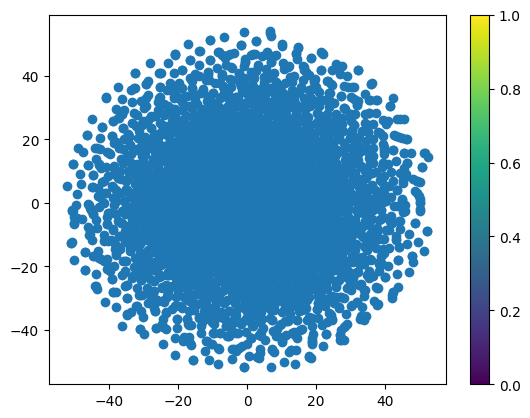

In [10]:
from sklearn.manifold import TSNE

def run_tsne(data, num_dimensions=2, perplexity=30.0, learning_rate=200.0, num_iterations=1000):
    # Create t-SNE object
    tsne = TSNE(n_components=num_dimensions, perplexity=perplexity, learning_rate=learning_rate, n_iter=num_iterations)
    
    # Run t-SNE on the data
    embedded_data = tsne.fit_transform(data)
    
    return embedded_data
import matplotlib.pyplot as plt

def plot_tsne(embedded_data):
    # Create a scatter plot of the embedded data
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
    plt.colorbar()
    plt.show()

# Example usage
import numpy as np

# Generate random data
data = np.asarray(model.wv.vectors)

# Run t-SNE
embedded_data = run_tsne(data)

# Print the embedded data

plot_tsne(embedded_data)

In [9]:
model.save('student.model')